# NSVM

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
print("Tensor Flow version {}".format(tf.__version__))

Tensor Flow version 0.10.0


## Load data

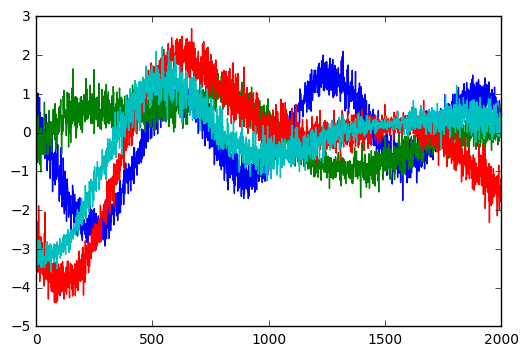

In [2]:
#To load data
datas = np.load("batch_data.npz")
data = datas["DATA"]
true_mu = datas["MU"]
true_nu = datas["NU"]
plt.figure()
plt.plot(data[0])
plt.plot(data[1])
plt.plot(data[2])
plt.plot(data[3])

In [3]:
EMBED_DIM = 10
LEN = 2000
TRAIN_LEN = 1500   #Use first 1500 for training and the rest for testing
BATCH_NUM = len(data)


X_raw = np.zeros([BATCH_NUM, LEN, 1])
X_raw[:, :,0] = data


#Time delay Embedding: 
xbat = X_raw.shape[0]
xlen = X_raw.shape[1]
xwid = X_raw.shape[2]
newlen = xlen - EMBED_DIM + 1
newwid = xwid * EMBED_DIM
Xs = np.zeros((xbat, newlen, newwid))
#print X_test_raw.shape
for i in range(EMBED_DIM):
    Xs[:, :, i*xwid:(i+1)*xwid] = X_raw[:, i:i+newlen, :]

#print Xs
X_train = Xs[:,:TRAIN_LEN,:]
X_test = Xs[:,:,:]
print X_train.shape
print X_test.shape

(256, 1500, 10)
(256, 1991, 10)


## Construct the graph

In [4]:
N_x = EMBED_DIM
N_hi = 10
N_z = 2
N_hg = 10
N_o = 1
T = TRAIN_LEN
L = 30
LEARNING_RATE = 0.001

DROPOUT = 0

Dtype = tf.float32

In [5]:
tf.reset_default_graph()
xs = tf.placeholder(Dtype, [None, T, N_x])
rv = tf.placeholder(Dtype, [None, L, T, N_z])
outs = xs[:, :, N_x-N_o:N_x]

eps = 1e-5

def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def biases(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


#Inference Net
with tf.variable_scope("InfNet"):
    GRUcell = tf.nn.rnn_cell.GRUCell(num_units = N_hi)
    GRUcell = tf.nn.rnn_cell.DropoutWrapper(GRUcell, output_keep_prob = 1 - DROPOUT)
    cell = tf.nn.rnn_cell.MultiRNNCell([GRUcell])
    
    hi, states = tf.nn.dynamic_rnn(
        cell,
        inputs = xs,
        sequence_length = None,
        dtype = Dtype
    )
    
    hi_flat = tf.reshape(hi, [-1, N_hi])
    
    W_fc_i = weights([N_hi, 2*N_z])
    b_fc_i = weights([2*N_z])
    outi_flat = tf.matmul(hi_flat, W_fc_i) + b_fc_i
    outi = tf.reshape(outi_flat, [-1, T, 2*N_z])

    mu_z, log_nu_z = tf.split(2, 2, outi) #[M, T, N_z]
    nu_z = tf.exp(log_nu_z) + eps      #use exp to be sure that variance are greater than zero.


zs = tf.expand_dims(mu_z, 1)+ rv * tf.expand_dims(tf.sqrt(nu_z), 1)  #zs : [M, L, T, N_z]
x_extd = tf.pack([xs]*L, 1)

x_and_z_flat = tf.reshape(tf.concat(3, [zs, x_extd]), [-1, T, N_x+N_z] )   #the input of generation net

with tf.variable_scope("GenNet"):
    GRUcell = tf.nn.rnn_cell.GRUCell(num_units = N_hg)
    GRUcell = tf.nn.rnn_cell.DropoutWrapper(GRUcell, output_keep_prob = 1 - DROPOUT)
    cell = tf.nn.rnn_cell.MultiRNNCell([GRUcell])
    
    hg, final_state = tf.nn.dynamic_rnn(
        cell,
        inputs = x_and_z_flat,
        sequence_length = None,
        dtype = Dtype
    )
    #hg : [M*L, T, N_hg]
    
    hg_flat = tf.reshape(hg, [-1, N_hg])
    
    W_fc_g = weights([N_hg, 2*N_o])
    b_fc_g = weights([2*N_o])
    outg_flat = tf.matmul(hg_flat, W_fc_g) + b_fc_g
    outg = tf.reshape(outg_flat, [-1, L, T, 2*N_o])
    
    mu_x, log_nu_x = tf.split(3, 2, outg) #[M, L, T, N_x]
    nu_x = tf.exp(log_nu_x) + eps
    
KL = 0.5 * (tf.reduce_mean(mu_z**2) + tf.reduce_mean(nu_z) - tf.reduce_mean(tf.log(nu_z)))
EXP = -0.5 * (tf.reduce_mean(tf.log(nu_x[:,:,:T-1])) + tf.reduce_mean((tf.expand_dims(outs[:,1:], 1) - mu_x[:,:,:T-1])**2 / nu_x[:,:,:T-1]))


loss = -(EXP - KL)
optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
fetch_loss = [loss]

mu_x_pred = tf.reduce_mean(mu_x, 1)
nu_x_pred = tf.reduce_mean(nu_x, 1)

## Train the model

In [6]:
# hparams pt. 3
NUM_EPOCHS = 5000
SUMMARY_FREQ = 5
SAVE_FREQ = 50
SAVE_PATH = 'NSVM-synthetic-checkpoint'

In [7]:
init = tf.initialize_all_variables()
saver = tf.train.Saver()
RESTORE_FLAG = False # if TRUE, pretrained model will be restored and trained
M = 128
random_v = np.random.randn(M,L,T,N_z)

with tf.Session() as sess:
    print('=======================================================================================================')
    sess_start = datetime.now()
    print('training session starts @ {}'.format(sess_start))
    print('-------------------------------------------------------------------------------------------------------')
    
    if RESTORE_FLAG is not True:
        sess.run(init)
    else:
        checkpoint_path = tf.train.latest_checkpoint('')
        saver.restore(sess, checkpoint_path)
        print('-------------------------------------------------------------------------------------------------------')
        print('{}, model loaded from file: {}'
              .format(datetime.now(), checkpoint_path))
        print('-------------------------------------------------------------------------------------------------------')
        
    for epoch in range(NUM_EPOCHS):
        if (epoch % SUMMARY_FREQ == 0):
            loss = 0
            for i in range(BATCH_NUM / M):
                feed_data = X_train[i*M:(i+1)*M]
                _, loss_cur = sess.run(fetches = [optimizer, fetch_loss], feed_dict = {xs:feed_data, rv:random_v})
                loss = (loss * i + loss_cur[0]) / (i+1)
            print('{}, epoch {}: lr = {}, loss = {}'.format(datetime.now(), epoch, LEARNING_RATE, loss))
        else:
            for i in range(BATCH_NUM / M):
                feed_data = X_train[i*M:(i+1)*M]
                sess.run(fetches = optimizer, feed_dict = {xs:feed_data, rv:random_v})

        
        if ((epoch+1) % SAVE_FREQ == 0):
            checkpoint_path = saver.save(sess, SAVE_PATH, epoch+1)
            print('-------------------------------------------------------------------------------------------------------')
            print('{}, model saved in file: {}'.format(datetime.now(), checkpoint_path))
            print('-------------------------------------------------------------------------------------------------------')
            
            
    sess_end = datetime.now()
    print('-------------------------------------------------------------------------------------------------------')
    print('training session ends   @ {}'.format(sess_end))
    print('=======================================================================================================')

training session starts @ 2016-11-04 19:00:21.016346
-------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

## Test the model

In [8]:
T = LEN-EMBED_DIM+1
M = BATCH_NUM

In [9]:
#Re-compile the model, since the length T needs to be modified
tf.reset_default_graph()
xs = tf.placeholder(Dtype, [None, T, N_x])
rv = tf.placeholder(Dtype, [None, L, T, N_z])
outs = xs[:, :, N_x-N_o:N_x]

eps = 1e-5

def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def biases(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


#Inference Net
with tf.variable_scope("InfNet"):
    GRUcell = tf.nn.rnn_cell.GRUCell(num_units = N_hi)
    GRUcell = tf.nn.rnn_cell.DropoutWrapper(GRUcell, output_keep_prob = 1 - DROPOUT)
    cell = tf.nn.rnn_cell.MultiRNNCell([GRUcell])
    
    hi, states = tf.nn.dynamic_rnn(
        cell,
        inputs = xs,
        sequence_length = None,
        dtype = Dtype
    )
    
    hi_flat = tf.reshape(hi, [-1, N_hi])
    
    W_fc_i = weights([N_hi, 2*N_z])
    b_fc_i = weights([2*N_z])
    outi_flat = tf.matmul(hi_flat, W_fc_i) + b_fc_i
    outi = tf.reshape(outi_flat, [-1, T, 2*N_z])

    mu_z, log_nu_z = tf.split(2, 2, outi) #[M, T, N_z]
    nu_z = tf.exp(log_nu_z) + eps      #use exp to be sure that variance are greater than zero.


zs = tf.expand_dims(mu_z, 1)+ rv * tf.expand_dims(tf.sqrt(nu_z), 1)  #zs : [M, L, T, N_z]
x_extd = tf.pack([xs]*L, 1)

x_and_z_flat = tf.reshape(tf.concat(3, [zs, x_extd]), [-1, T, N_x+N_z] )   #the input of generation net

with tf.variable_scope("GenNet"):
    GRUcell = tf.nn.rnn_cell.GRUCell(num_units = N_hg)
    GRUcell = tf.nn.rnn_cell.DropoutWrapper(GRUcell, output_keep_prob = 1 - DROPOUT)
    cell = tf.nn.rnn_cell.MultiRNNCell([GRUcell])
    
    hg, final_state = tf.nn.dynamic_rnn(
        cell,
        inputs = x_and_z_flat,
        sequence_length = None,
        dtype = Dtype
    )
    #hg : [M*L, T, N_hg]
    
    hg_flat = tf.reshape(hg, [-1, N_hg])
    
    W_fc_g = weights([N_hg, 2*N_o])
    b_fc_g = weights([2*N_o])
    outg_flat = tf.matmul(hg_flat, W_fc_g) + b_fc_g
    outg = tf.reshape(outg_flat, [-1, L, T, 2*N_o])
    
    mu_x, log_nu_x = tf.split(3, 2, outg) #[M, L, T, N_x]
    nu_x = tf.exp(log_nu_x) + eps
    
KL = 0.5 * (tf.reduce_mean(mu_z**2) + tf.reduce_mean(nu_z) - tf.reduce_mean(tf.log(nu_z)))
EXP = -0.5 * (tf.reduce_mean(tf.log(nu_x[:,:,:T-1])) + tf.reduce_mean((tf.expand_dims(outs[:,1:], 1) - mu_x[:,:,:T-1])**2 / nu_x[:,:,:T-1]))


loss = -(EXP - KL)
optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
fetch_loss = [loss]

mu_x_pred = tf.reduce_mean(mu_x, 1)
nu_x_pred = tf.reduce_mean(nu_x, 1)

In [10]:
X_test_input = X_test
test_data = data[:,EMBED_DIM:]
test_mu = true_mu[:,EMBED_DIM:]
test_nu = true_nu[:,EMBED_DIM:]
random_v_test = np.random.randn(M, L, T, N_z)
with tf.Session() as sess:
    saver = tf.train.Saver()
    #checkpoint_path = tf.train.latest_checkpoint('')
    checkpoint_path = 'NSVM-synthetic-model'
    saver.restore(sess, checkpoint_path)
    print('{}, model loaded from file: {}'.format(datetime.now(), checkpoint_path))
    mu_pred, nu_pred = sess.run(fetches = [mu_x_pred, nu_x_pred], feed_dict = {xs:X_test_input, rv:random_v_test})
    
    mu_pred = mu_pred[:,:T-1,0]
    nu_pred = nu_pred[:,:T-1,0]
    
    print mu_pred.shape
    print test_data.shape
    
    t_start = TRAIN_LEN-EMBED_DIM+1
    nll_test = -np.mean(-np.log(2.50663*np.sqrt(nu_pred[:,t_start:])) - (mu_pred[:,t_start:] - test_data[:,t_start:])**2 / 2 / (nu_pred[:,t_start:]),axis = 1  )
    mu_mse_test = np.mean((mu_pred[:,t_start:] - test_mu[:,t_start:])**2,axis = 1)
    sigma_mse_test = np.mean((np.sqrt(nu_pred[:,t_start:]) - np.sqrt(test_nu[:,t_start:]))**2,axis = 1)
    print ("NLL_test = "+str(np.mean(nll_test)))
    print ("mu_MSE_test = " +str(np.mean(mu_mse_test)))
    print ("sigma_MSE_test = "+str(np.mean(sigma_mse_test)))

    smoothness = np.mean(np.std(np.sqrt(nu_pred[:,1:]) - np.sqrt(nu_pred[:,:-1]), axis = 1))
    print ("var_smoothness = "+str(smoothness))

2016-11-04 19:00:34.789184, model loaded from file: NSVM-synthetic-model
(256, 1990)
(256, 1990)
NLL_test = 0.0393167627417
mu_MSE_test = 0.00239269123739
sigma_MSE_test = 0.000617805835344
var_smoothness = 0.00432148


In [58]:
np.savez("nsvm_synthetic_result.npz", NLL = nll_test, MU = mu_mse_test, NU = sigma_mse_test)

## To show a single curve

NSVM-synthetic-model
2016-11-04 19:00:42.109137, model loaded from file: NSVM-synthetic-model
(1990,)
(1990,)
NLL_test = -0.0183825890844
mu_MSE_test = 0.00112271003726
sigma_MSE_test = 0.00133410083978


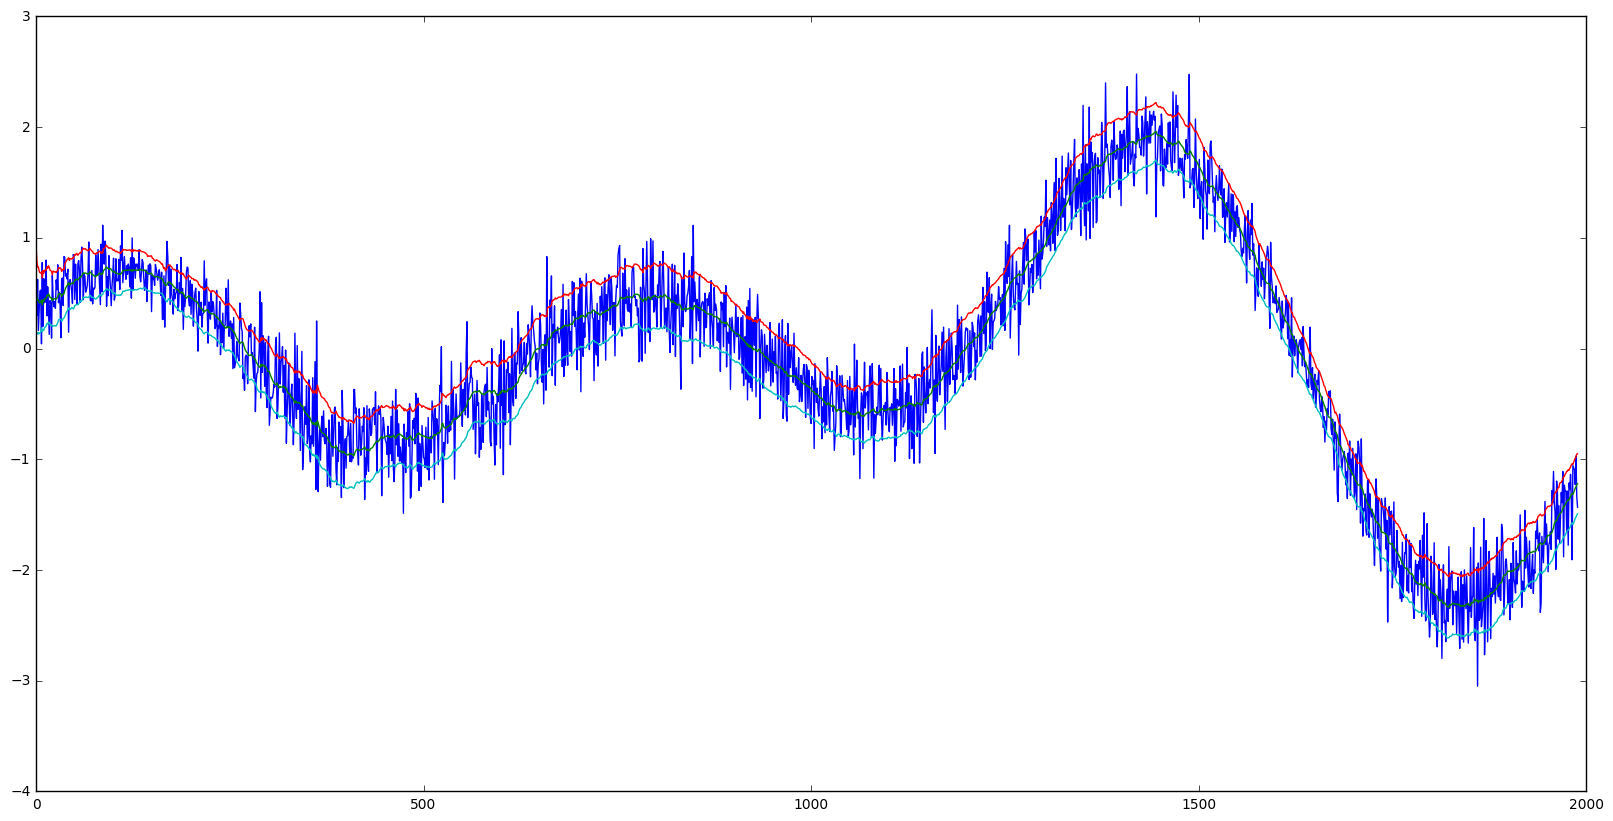

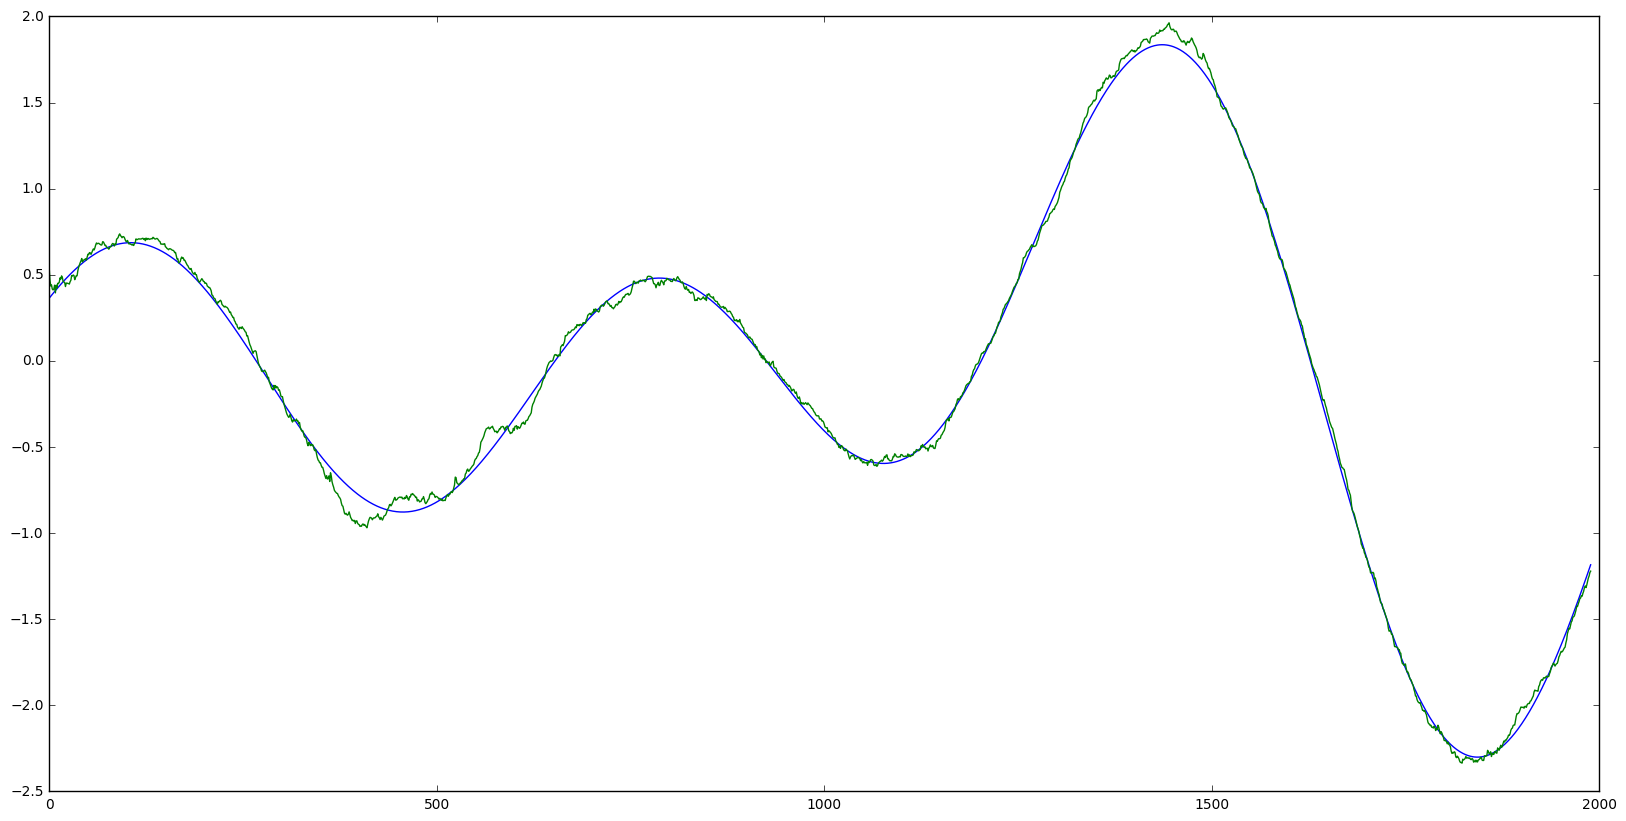

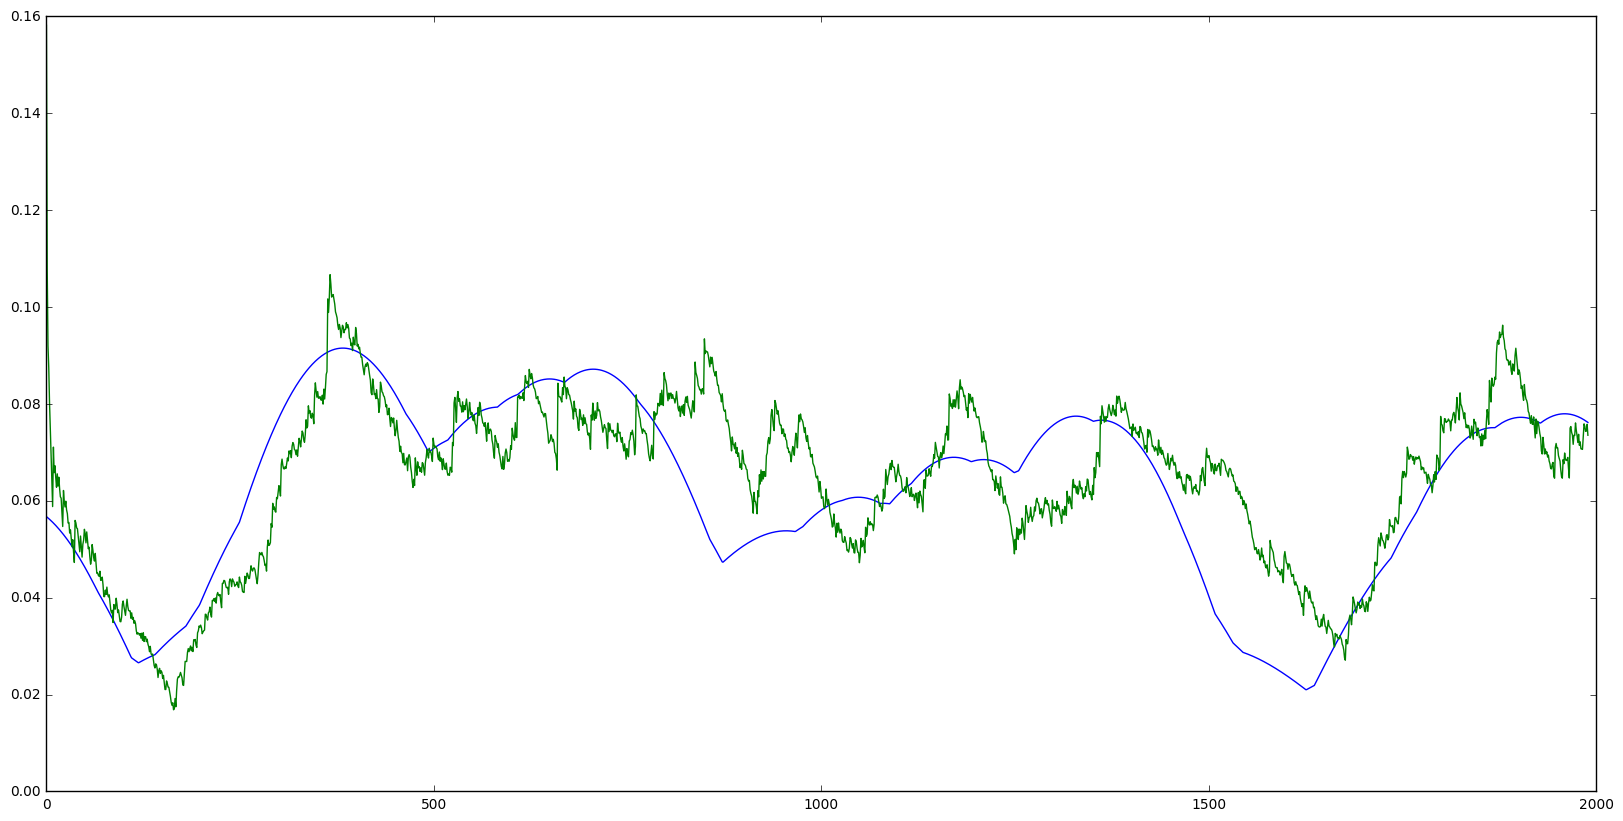

In [11]:
M = 1

test_id = 17     #Select the id of the curve you want to plot
X_test_input = X_test[test_id:test_id+1]
test_data = data[test_id, EMBED_DIM:]
test_mu = true_mu[test_id, EMBED_DIM:]
test_nu = true_nu[test_id, EMBED_DIM:]
random_v_test = np.random.randn(M, L, T, N_z)

with tf.Session() as sess:
    saver = tf.train.Saver()
    #checkpoint_path = tf.train.latest_checkpoint('')
    checkpoint_path = 'NSVM-synthetic-model'
    print checkpoint_path
    saver.restore(sess, checkpoint_path)
    print('{}, model loaded from file: {}'.format(datetime.now(), checkpoint_path))
    mu_pred, nu_pred = sess.run(fetches = [mu_x_pred, nu_x_pred], feed_dict = {xs:X_test_input, rv:random_v_test})
    
    mu_pred = mu_pred[0,:T-1,0]
    nu_pred = nu_pred[0,:T-1,0]
    
    print mu_pred.shape
    print test_data.shape
    
    t_start = TRAIN_LEN-EMBED_DIM+1
    nll_test = -np.mean( -np.log(2.50663*np.sqrt(nu_pred[t_start:])) - (mu_pred[t_start:] - test_data[t_start:])**2 / 2 / (nu_pred[t_start:])  )
    mu_mse_test = np.mean((mu_pred[t_start:] - test_mu[t_start:])**2)
    sigma_mse_test = np.mean((np.sqrt(nu_pred[t_start:]) - np.sqrt(test_nu[t_start:]))**2)
    print ("NLL_test = "+str(nll_test))
    print ("mu_MSE_test = " +str(mu_mse_test))
    print ("sigma_MSE_test = "+str(sigma_mse_test))

    
    pred_range = np.array(range(LEN - EMBED_DIM + 1)) + EMBED_DIM - 1
    plt.figure(figsize = (20,10))
    plt.plot(test_data)
    plt.plot(mu_pred)
    plt.plot(mu_pred + np.sqrt(nu_pred))
    plt.plot(mu_pred - np.sqrt(nu_pred))
    plt.figure(figsize = (20,10))
    plt.plot(test_mu)
    plt.plot(mu_pred)
    plt.figure(figsize = (20,10))
    plt.plot(test_nu)
    plt.plot(nu_pred)